In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('input/Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')
data.shape

(144, 1)

In [3]:
data.head()

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0


## Missing Values

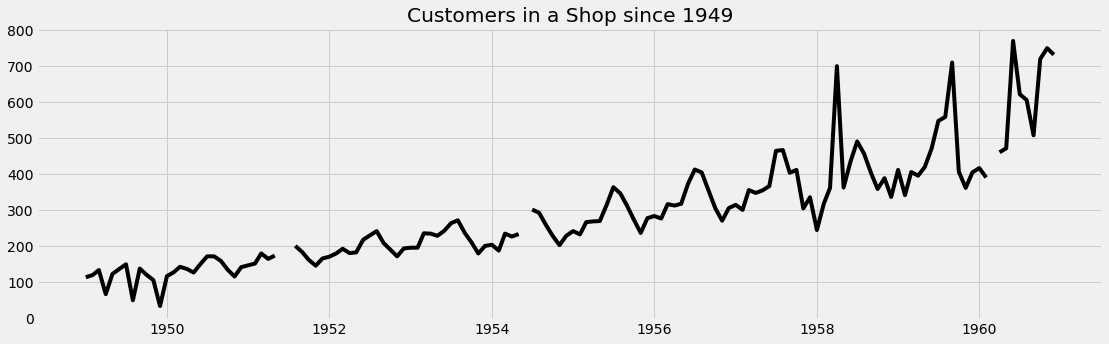

In [4]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Customers in a Shop since 1949")
plt.show()

## Linear Interpolation

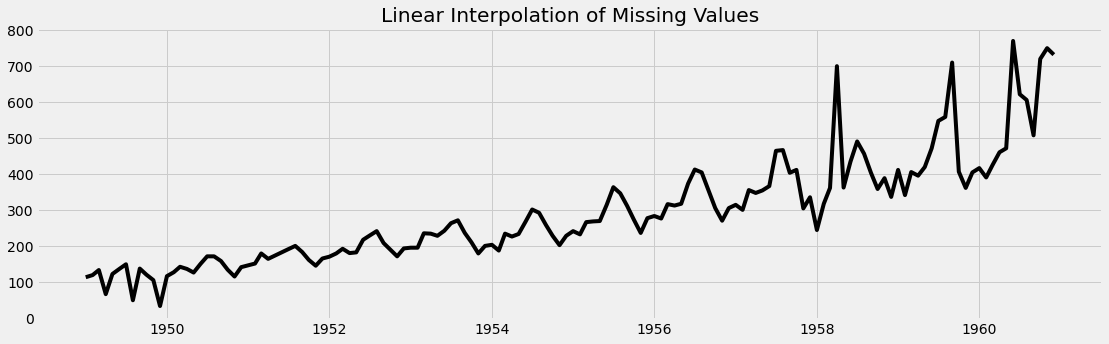

In [5]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

In [6]:
data['Customers'] = data['Customers_linear']

## Outliers Treatment

In [7]:
# outliers treatment

data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622
# lets also check the null values again
data.isnull().sum()

Customers           0
Customers_linear    0
dtype: int64

## Time Series Decomposition

In [8]:
import statsmodels.api as sm

### Additive Seasonal Decomposition

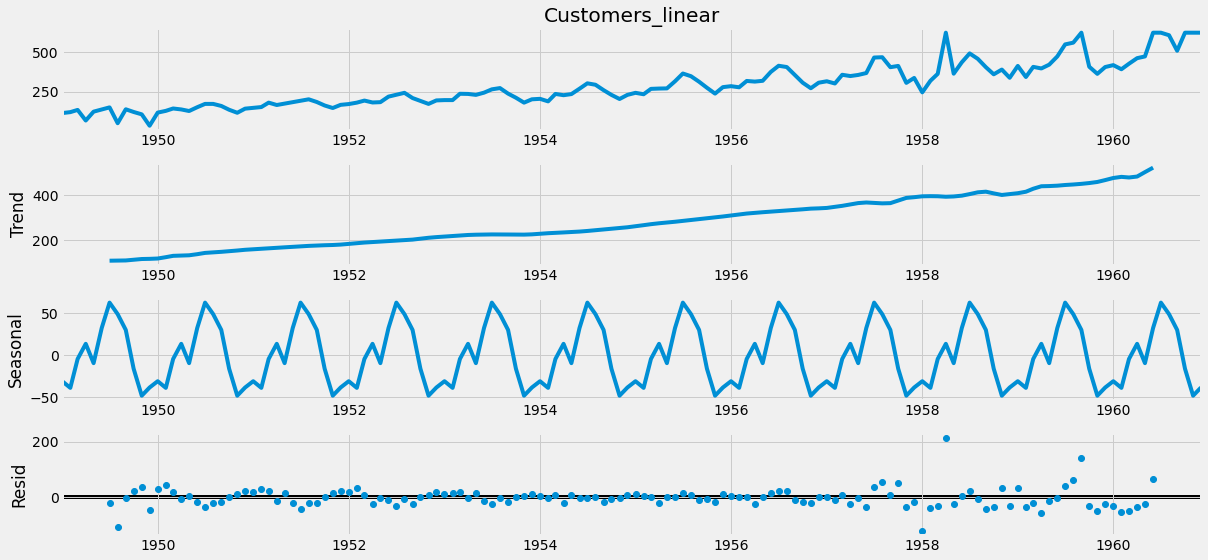

In [9]:
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(data['Customers_linear'], model='additive')
decomposition.plot()
                                          
plt.show()

### Multiplicative Seasonal Decomposition

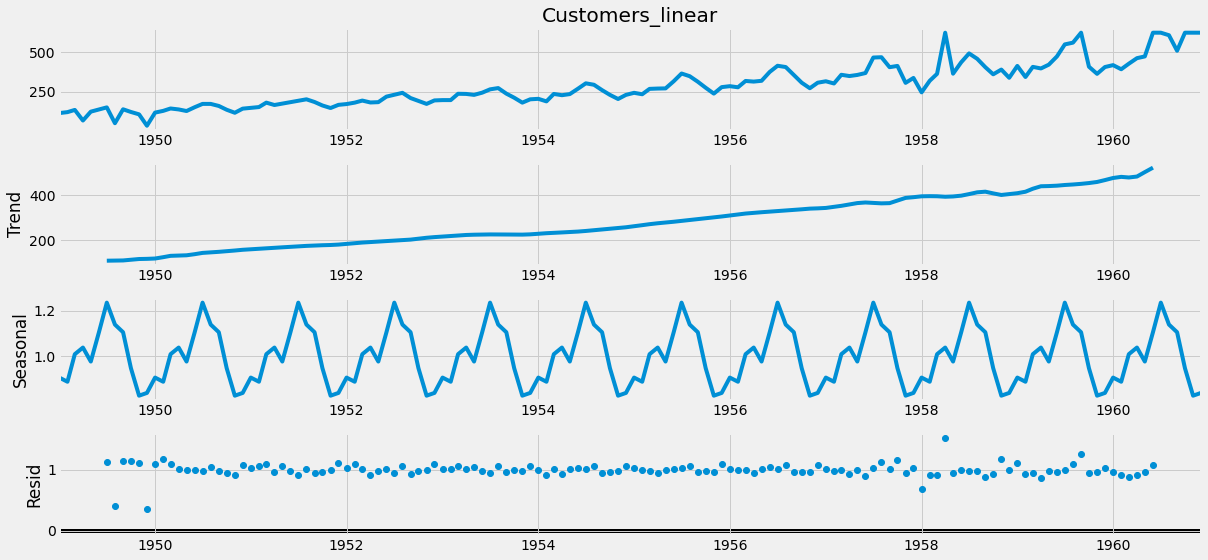

In [10]:
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(data['Customers_linear'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting Train and Test data

In [11]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

In [12]:
# lets check the shape of train

print(train.shape)
train.tail()

(115, 2)


,Customers,Customers_linear
Date,,
1958-03-01,362.0,362.0
1958-04-01,700.0,622.0
1958-05-01,363.0,363.0
1958-06-01,435.0,435.0
1958-07-01,491.0,491.0


In [13]:
# lets check the shape of test

print(train.shape)
test.head()

(115, 2)


,Customers,Customers_linear
Date,,
1958-08-01,457.0,457.0
1958-09-01,404.0,404.0
1958-10-01,359.0,359.0
1958-11-01,389.0,389.0
1958-12-01,337.0,337.0


# Naive Method
The naive method is the simplest method of all forecasting methods. It looks at the last historical data and extrapolates it for all the future values without adjusting or attempting to establish causal factors.

In [14]:
y_naive = test.copy()
y_naive['forecasted_naive'] = train['Customers'][length_train-1]

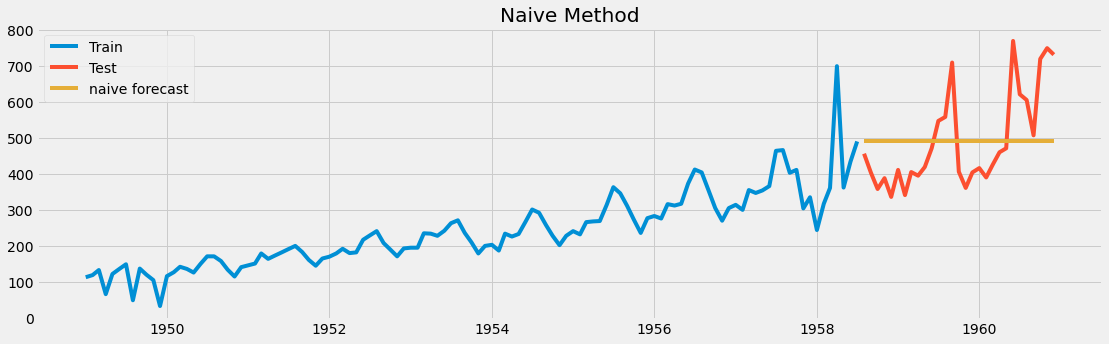

In [15]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_naive['forecasted_naive'], label = 'naive forecast')

plt.legend()
plt.title('Naive Method')
plt.show()

# Simple Average Method
In this method, we take the future predictions equal to the average of all the historical data.

In [16]:
y_avg = test.copy()

y_avg['forecasted_avg'] = train['Customers'].mean()

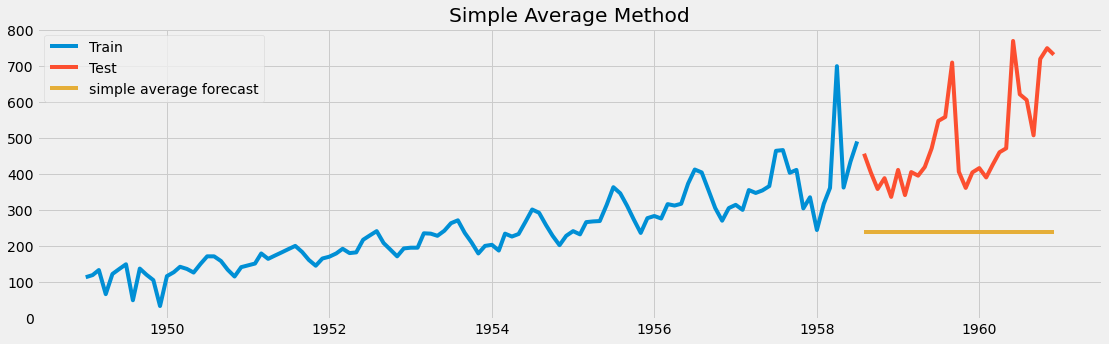

In [17]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_avg['forecasted_avg'], label = 'simple average forecast')

plt.legend()
plt.title('Simple Average Method')
plt.show()

In [36]:
mfe = np.round(np.mean(test['Customers']-y_avg['forecasted_avg']),2)
mfe

251.1

In [38]:
mae = np.round(np.mean(np.abs(test['Customers']-y_avg['forecasted_avg'])),2)
mae

251.1

In [40]:
mape = np.round(np.mean(np.abs(test['Customers']-y_avg['forecasted_avg'])/test['Customers'])*100,2)
mape

47.94

In [42]:
from sklearn.metrics import mean_squared_error
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'], y_avg['forecasted_avg'])),2)
rmse

283.62

# Simple Moving Average Method
In this method, we take the future predictions equal to the average of a moving window. A window can be a time period of 3 months, 6 months, 9 months or 1 year.

In [20]:
y_moving = data.copy()

window = 9
y_moving["moving_average_forecast"] = data['Customers'].rolling(window).mean()
y_moving['moving_average_forecast'][length_train:] = y_moving['moving_average_forecast'][length_train-1]

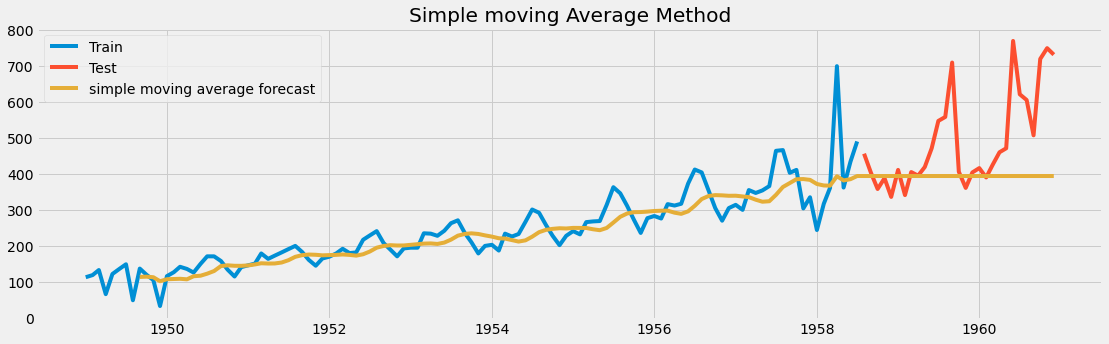

In [21]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_moving['moving_average_forecast'], label = 'simple moving average forecast')

plt.legend()
plt.title('Simple moving Average Method')
plt.show()

# Simple Exponential Smoothing


In [22]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train['Customers'])
model_fit = model.fit(smoothing_level=0.2)
model_fit.params
y_exp = test.copy()
y_exp['Exponential_forecast'] = model_fit.forecast(24)

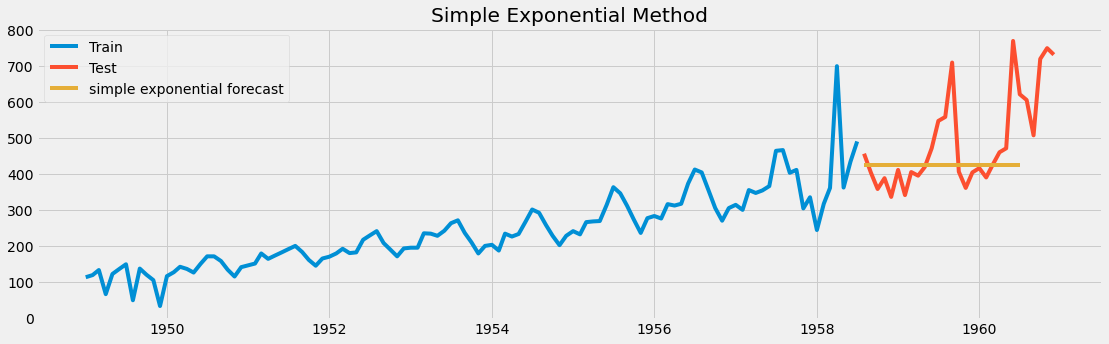

In [23]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_exp['Exponential_forecast'], label = 'simple exponential forecast')

plt.legend()
plt.title('Simple Exponential Method')
plt.show()

# Holt Exponential Smoothing
Holt’s exponential smoothing captures the level and trend of time series in the forecast.

The forecast equation is a function of both level and trend.

y(t+1) = l(t) +b(t) 

Where l(t) is the level component and b(t) is the trend component.

The trend component is calculated as shown

b(t) = β(l(t) - l(t-1)) + (1-β)b(t-1) 

Here beta is the smoothing parameter for trend.


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['Customers'], seasonal_periods=12, trend='multiplicative')
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.04)
model_fit.params
y_holtexponential = test.copy()
y_holtexponential['holtexponential_forecast'] = model_fit.forecast(24)

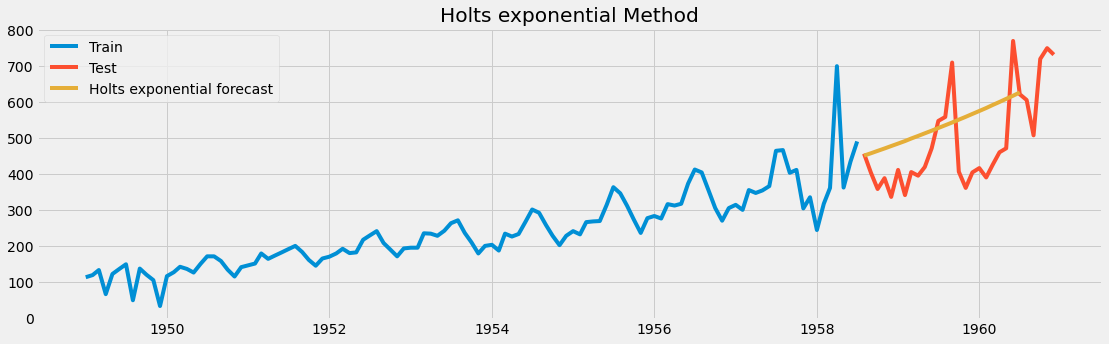

In [25]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_holtexponential['holtexponential_forecast'], label = 'Holts exponential forecast')

plt.legend()
plt.title('Holts exponential Method')
plt.show()

# Holt Winter Exponential Smoothing
This techniques forecasts based on level, trend and seasonality.
The forecast equation for this method includes seasonality.
	
y(t+1) = l(t)+b(t)+s(t+1-m) 
Here m is the number of time a season repeats in a time period.

In [32]:
model = ExponentialSmoothing(train['Customers'], seasonal_periods=12, trend='multiplicative', seasonal='additive')
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.04)
model_fit.params
y_holtwinter = test.copy()
y_holtwinter['holtwinter_forecast'] = model_fit.forecast(36)

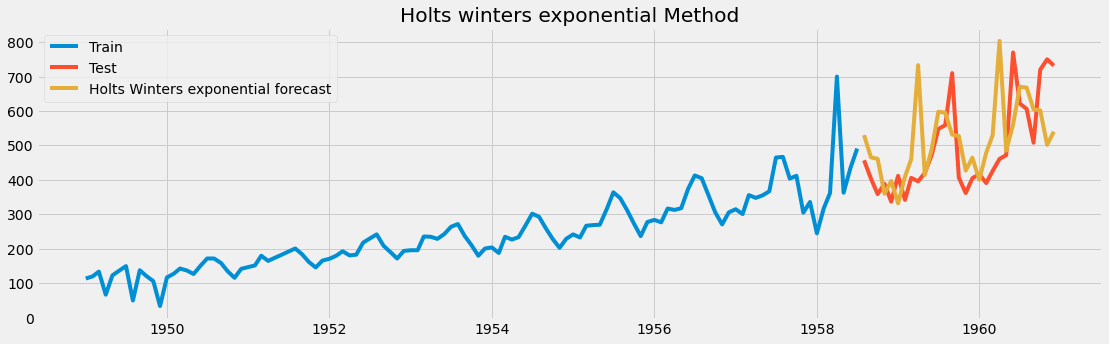

In [33]:
plt.rcParams['figure.figsize'] = (17,5)

plt.plot(train['Customers'], label = 'Train')
plt.plot(test['Customers'], label = 'Test')
plt.plot(y_holtwinter['holtwinter_forecast'], label = 'Holts Winters exponential forecast')

plt.legend()
plt.title('Holts winters exponential Method')
plt.show()

In [37]:
mfe = np.round(np.mean(test['Customers']-y_holtwinter['holtwinter_forecast']),2)
mfe

-26.94

In [39]:
mae = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])),2)
mae

101.23

In [41]:
mape = np.round(np.mean(np.abs(test['Customers']-y_holtwinter['holtwinter_forecast'])/test['Customers'])*100,2)
mape

20.64

In [43]:
rmse = np.round(np.sqrt(mean_squared_error(test['Customers'], y_holtwinter['holtwinter_forecast'])),2)
rmse

133.62